In [1]:
import numpy as np
from scipy.optimize import root_scalar

# ==========================
# Constants from the paper
# ==========================
Tc = 647.096  # [K] Critical temperature of water
pc = 22.064e6  # [Pa] Critical pressure of water

# Molar masses [kg/mol]
M_LiBr = 0.08685
M_H2O = 0.018015268
# Coefficients for pressure equation (Eq. 1)
a = [-2.41303e2,1.91750e7,-1.75521e8,3.25430e7,3.92571e2,-2.12626e3,1.85127e8,1.91216e3]
m = [3, 4, 4, 8, 1, 1, 4, 6]
n = [0, 5, 6, 3, 0, 2, 6, 0]
t = [0, 0, 0, 0, 1, 1, 1, 1]
# Coefficients for water vapor pressure (Eq. 28)
a_ps = [-7.85951783, 1.84408259, -11.7866497,
        22.6807411, -15.9618719, 1.80122502] 
b_ps = [1.0, 1.5, 3.0, 3.5, 4.0, 7.5]
# ===========================================
# Saturation pressure of pure water, p_s(T)
# ===========================================
def ps_water(T):
    T=float(T)
    theta = 1 - T / Tc
    ln_ps = (Tc / T) * sum(a * theta**b for a, b in zip(a_ps, b_ps))
    return pc * np.exp(ln_ps)

# ===========================================
# Pressure equation of LiBr-H2O: p(T, x)
# ===========================================
def p_libr(T, x):
    q = T - sum(
        a[i] * x**m[i] * (0.4 - x)**n[i] * (T / Tc)**t[i]
        for i in range(8)
    )
    return ps_water(q)

# ===========================================
# Solve for x at given T and p
# ===========================================
def find_x_given_T_p(T, p_target):
    T = float(T)
    p_target = float(p_target)
    def objective(x):
        if x <= 0 or x >= 0.74:
            return 1e6
        return p_libr(T, x) - p_target

    a, b = 0.001, 0.73
    fa = objective(a)
    fb = objective(b)

    # Check if a solution is physically possible
    if np.sign(fa) == np.sign(fb):
        return None  # no sign change = no root

    result = root_scalar(objective, bracket=[a, b], method='bisect')

    # ❗ Additional guard to avoid edges
    if result.converged and 0.01 < result.root < 0.72:
        return x_to_w(result.root)
    else:
        return None  # discard if root is on edge



# ===========================================
# Convert molar fraction x → mass fraction w
# ===========================================
def x_to_w(x):
    m1 = x * M_LiBr
    m2 = (1 - x) * M_H2O
    return m1 / (m1 + m2)

from CoolProp.CoolProp import PropsSI

MLiBr = 0.08685      # kg/mol
MH2O = 0.018015      # kg/mol
T_c = 647.096        # K
T_0 = 221.0          # K
h_c = 37548.5        # J/mol

# Coefficients
a_h = [
    2.27431, -7.99511, 385.239, -16394, -422.562,
    0.113314, -8.33474, -17383.3, 6.49763, 3245.52,
    -13464.3, 39932.2, -258877, -0.00193046, 2.80616,
    -40.4479, 145.342, -2.74873, -449.743, -12.1794,
    -0.00583739, 0.233910, 0.341888, 8.85259, -17.8731,
    0.0735179, -0.000179430, 0.00184261, -0.00624282, 0.00684765
]
m_h = [1,1,2,3,6,1,3,5,4,5,5,6,6,1,2,2,2,5,6,7,1,1,2,2,2,3,1,1,1,1]
n_h = [0,1,6,6,2,0,0,4,0,4,5,5,6,0,3,5,7,0,3,1,0,4,2,6,7,0,0,1,2,3]
t_h = [0,0,0,0,0,1,1,1,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5]

def mass_to_molar_fraction(w):
    return (w / MLiBr) / (w / MLiBr + (1 - w) / MH2O)

def h_LiBr(T, w):
    x = mass_to_molar_fraction(w)
    h_w_kg = PropsSI('H', 'T', T, 'Q', 0, 'Water')  # J/kg
    h_w_mol = h_w_kg * MH2O                        # J/mol
    second = 0.0
    for i in range(30):
        second += a_h[i] * x**m_h[i] * abs(0.4 - x)**n_h[i] * (T_c / (T - T_0))**t_h[i]
    # Total molar enthalpy [J/mol]
    h_molar = (1 - x) * h_w_mol + h_c * second
    M_mix = x * MLiBr + (1 - x) * MH2O
    h_mass = h_molar / M_mix  # J/kg
    return h_mass

s_c = 79.3933      # J/mol·K
s_ai = [
    1.53091, -4.52564, 698.302, -21666.4, -1475.33,
    0.0847012, -6.59523, -29533.1, 0.00956314, -0.188679,
    9.31752, 5.78104, 13893.1, -17176.2, 415.108,
    -55564.7, -0.00423409, 30.5242, -1.67620, 14.8283,
    0.00303055, -0.0401810, 0.149252, 2.59240, -0.177421,
    -0.0000699650, 0.000605007, -0.00165228, 0.00122966
]
s_mi = [1,1,2,3,6,1,3,5,1,2,2,4,5,5,6,6,1,3,5,7,1,1,1,2,3,1,1,1,1]
s_ni = [0,1,6,6,2,0,0,4,0,0,4,0,4,5,2,5,0,4,0,1,0,2,4,7,1,0,1,2,3]
s_ti = [0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,5,5,5,5]

def mass_to_molar_fraction(w):
    return (w / MLiBr) / (w / MLiBr + (1 - w) / MH2O)

def s_LiBr(T, w):
    x = mass_to_molar_fraction(w)

    # Get entropy of pure water (J/kg·K) and convert to J/mol·K
    s_w_kgK = PropsSI('S', 'T', T, 'Q', 0, 'Water')  # J/kg·K
    s_w_molK = s_w_kgK * MH2O                      # J/mol·K
    second = sum(
        ai * x**mi * abs(0.4 - x)**ni * (T_c / (T - T_0))**ti
        for ai, mi, ni, ti in zip(s_ai, s_mi, s_ni, s_ti)
    )

    # Molar entropy of the solution [J/mol·K]
    s_molar = (1 - x) * s_w_molK + s_c * second
    M_mix = x * MLiBr + (1 - x) * MH2O
    s_mass = s_molar / M_mix  # J/kg·K
    return s_mass

from scipy.optimize import root_scalar
def find_T_given_h_x(h_target, x_mass, T_bounds=(273.15, 473.15)):
    """
    Invert the h_LiBr function to solve for T given enthalpy and mass fraction.
    h_target: enthalpy [J/kg]
    x_mass: LiBr mass fraction
    T_bounds: bounds for T in Kelvin
    """
    h_target=float(h_target)
    x_mass=float(x_mass)
    def objective(T):
        try:
            return h_LiBr(T, x_mass) - h_target
        except Exception:
            return 1e6  # fail safe if T is out of range

    result = root_scalar(objective, bracket=T_bounds, method='brentq')
    
    if result.converged:
        return result.root
    else:
        raise ValueError("Temperature solution did not converge.")



In [2]:
from sympy import symbols, Eq, solve

# Define groups of symbols
def solve_system(Temperature_evaporator,P_gascooler,Temperature_after_gascooler,Water_line_temperature,High_pressure_generator_temperature,Pressure_hpg,Low_pressure_generator_temperature,Adsorber_temperature,Condensor_temperature,Efficiency_gas_cooler_1,Efficiency_heat_exchanger_1,Efficiency_heat_exchanger_2,Vars_evaporator_temperature):

    solutions=dict()
    misc_equations=T_e_tcrs,n_c,n_t,rp,W_turbine,W_compressor,Q_e_tcrs,COP,efficiency,P2s,s2s,h2s,P_e_tcrs,P5s,s5s,h5s,T5s,mw1,mw2,E_gc1,E_shx_1,E_shx2,T_generator_hpg,P_generator_hpg,Q_generator_hpg,T_generator_lpg,P_generator_lpg,T_adsorber,P_adsorber,Q_adsorber,T_e_vars,P_e_vars,Q_e_vars,T_condensor,P_condensor,Q_condensor,w_strong_1,w_strong_2,w_strong_3,w_weak,m_strong_1,m_strong_2,m_strong_3,m_weak,m_ra,m_ra_1,m_ra_2,W_input_tcrs,n_exergy_tcrs,n_exergy_vars,n_exergy_total,COP_tcrs,COP_comb=symbols('T_e_tcrs,n_c,n_t,rp,W_turbine,W_compressor,Q_e_tcrs,COP,efficiency,P2s,s2s,h2s,P_e_tcrs,P5s,s5s,h5s,T5s,' \
    'mw1,mw2,E_gc1,E_shx_1,E_shx2,T_generator_hpg,P_generator_hpg,Q_generator_hpg,T_generator_lpg,P_generator_lpg,T_adsorber,P_adsorber,Q_adsorber,T_e_vars,P_e_vars,Q_e_vars,T_condensor,P_condensor,Q_condensor,w_strong_1,w_strong_2,w_strong_3,w_weak,m_strong_1,m_strong_2,m_strong_3,m_weak,m_ra,m_ra_1,m_ra_2,W_input_tcrs,n_exergy_tcrs,n_exergy_vars,n_exergy_total,COP_tcrs,COP_comb')
    P=symbols('P:27')
    h=symbols('h:27')
    x=symbols('x:27')
    w=symbols('w:27')
    s=symbols('s:27')
    m=symbols('m:27')
    T=symbols('T:27')
    all_symbols = T + P +w+ x +s+m +h+(misc_equations)

# Define the equations
    #point 1
    equation = [
        Eq(T[1],Temperature_evaporator),
        # Eq(T_e_tcrs,Temperature_evaporator),
        Eq(x[1],1),
        Eq(m[1],1)
    ]
    solutions.update(solve(equation, all_symbols) )
    equation=[
        Eq(P[1],PropsSI('P','T',solutions[T[1]],'Q',solutions[x[1]],'CO2')),
        Eq(h[1],PropsSI('H','T',solutions[T[1]],'Q',solutions[x[1]],'CO2')),
        Eq(s[1],PropsSI('S','T',solutions[T[1]],'Q',solutions[x[1]],'CO2')),  
              ]
    solutions.update(solve(equation, all_symbols) )
    
    #point  2s
    equation=[
        Eq(P2s,P_gascooler),
        Eq(s2s, solutions[s[1]])
    ]
    solutions.update(solve(equation, all_symbols))

    equation=[
        Eq(h2s,PropsSI('H','P',solutions[P2s],'S',solutions[s2s],'CO2')),
        #evaporator
        Eq(P_e_tcrs,solutions[P[1]]),
        Eq(rp,solutions[P2s]/solutions[P[1]]),
    ]
    solutions.update(solve(equation, all_symbols) )

    equation=[
         Eq(n_c,0.815+ 0.022*solutions[rp]-0.0041*(solutions[rp]**2)+0.0001*(solutions[rp]**3))
    ]
    solutions.update(solve(equation, all_symbols) )

    #point 2
    equation=[
        Eq(P[2],P_gascooler),
        Eq(m[2],1),
        Eq(h[2],solutions[h[1]]+(solutions[h2s]-solutions[h[1]])/solutions[n_c])
    ]
    solutions.update(solve(equation, all_symbols) )

    equation=[
        Eq(T[2],PropsSI('T','P',solutions[P[2]],'H',solutions[h[2]],'CO2')),
        Eq(s[2],PropsSI('S','P',solutions[P[2]],'H',solutions[h[2]],'CO2'))
    ]
    solutions.update(solve(equation, all_symbols) )

      #point 24
    equation=[
        Eq(T[24],Water_line_temperature),
        Eq(x[24],1),
    ]
    solutions.update(solve(equation, all_symbols) )
    
    equation=[
        Eq(h[24],PropsSI('H','T',solutions[T[24]],'Q',solutions[x[24]],'Water')),
        Eq(s[24],PropsSI('S','T',solutions[T[24]],'Q',solutions[x[24]],'Water')),
    ]
    solutions.update(solve(equation, all_symbols) )

    #point 23
    equation=[
        Eq(T[23],Water_line_temperature),
        Eq(x[23],0),
    ]
    solutions.update(solve(equation, all_symbols) )
    
    equation=[
        Eq(h[23],PropsSI('H','T',solutions[T[23]],'Q',solutions[x[23]],'Water')),
        Eq(s[23],PropsSI('S','T',solutions[T[23]],'Q',solutions[x[23]],'Water')),
    ]
    solutions.update(solve(equation, all_symbols) )

    #point 3
    equation=[
        Eq(m[3],1),
        Eq(P[3],P_gascooler),
        Eq(T[3],solutions[T[2]]-Efficiency_gas_cooler_1*(solutions[T[2]]-solutions[T[23]])),
    ]
    solutions.update(solve(equation, all_symbols) )

    equation=[
        Eq(h[3],PropsSI('H','T',solutions[T[3]],'P',solutions[P[3]],'CO2')),
        Eq(s[3],PropsSI('S','T',solutions[T[3]],'P',solutions[P[3]],'CO2')),
    ]
    solutions.update(solve(equation, all_symbols) )

    equation=[
        Eq(mw1,(solutions[h[2]]-solutions[h[3]])/(solutions[h[24]]-solutions[h[23]])),
        Eq(m[23],mw1),
        Eq(m[24],mw1),
    ]
    solutions.update(solve(equation, all_symbols) )

    #point 4
    equation=[
        Eq(m[4],1),
        Eq(P[4],P_gascooler),
        Eq(T[4],Temperature_after_gascooler),
    ]
    solutions.update(solve(equation, all_symbols) )

    equation=[
        Eq(s[4],PropsSI('S','T',solutions[T[4]],'P',solutions[P[4]],'CO2')),
        Eq(h[4],PropsSI('H','T',solutions[T[4]],'P',solutions[P[4]],'CO2')),
    ]
    solutions.update(solve(equation, all_symbols) )

    # point 5s
    equation=[
        Eq(s5s,solutions[s[4]]),
        Eq(P5s,solutions[P_e_tcrs]),
        Eq(T5s,Temperature_evaporator),
    ]
    solutions.update(solve(equation, all_symbols) )

    equation=[
        Eq(h5s,PropsSI('H','S',solutions[s5s],'P',solutions[P5s],'CO2')),
        # turbine efficiency
        Eq(n_t,0.6)
    ]
    solutions.update(solve(equation, all_symbols) )

    # point 5
    equation=[
        Eq(m[5],1),
        Eq(P[5],solutions[P_e_tcrs]),
        Eq(h[5],solutions[h[4]]-solutions[n_t]*(solutions[h[4]]-solutions[h5s]))
    ]
    solutions.update(solve(equation, all_symbols) )
    
    equation=[
        Eq(T[5],PropsSI('T','P',solutions[P[5]],'H',solutions[h[5]],'CO2')),
        Eq(s[5],PropsSI('S','P',solutions[P[5]],'H',solutions[h[5]],'CO2')),
    ]
    solutions.update(solve(equation, all_symbols) )



    equation=[
        Eq(T_e_vars,Vars_evaporator_temperature)
    ]
    solutions.update(solve(equation, all_symbols) )

    equation=[
        Eq(P_e_vars,PropsSI('P','T',solutions[T_e_vars],'Q',0,'Water')),
        Eq(P_adsorber,P_e_vars),
        Eq(T_adsorber,Adsorber_temperature),
        Eq(T_generator_hpg,High_pressure_generator_temperature),
        Eq(T_generator_lpg,Low_pressure_generator_temperature),
        Eq(T_condensor,Condensor_temperature),
        Eq(P_generator_hpg,Pressure_hpg),
    ]
    solutions.update(solve(equation, all_symbols) )

    equation=[
        Eq(P_condensor,PropsSI('P','T',solutions[T_condensor],'Q',0,'Water')),
        Eq(P_generator_lpg,P_condensor),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 17
    equation=[
        Eq(T[17],solutions[T_generator_lpg]),
        Eq(P[17],solutions[P_condensor]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
        Eq(h[17],PropsSI('H','P',solutions[P[17]],'T',solutions[T[17]],"Water")),
        Eq(s[17],PropsSI('S','P',solutions[P[17]],'T',solutions[T[17]],"Water")),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 14
    equation=[
        Eq(T[14],solutions[T_generator_hpg]),
        Eq(P[14],solutions[P_generator_hpg]),
        Eq(x[14],1),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
        Eq(h[14],PropsSI('H','P',solutions[P[14]],'T',solutions[T[14]],'Water')),
        Eq(s[14],PropsSI('S','P',solutions[P[14]],'T',solutions[T[14]],'Water')),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 15
    equation=[
        Eq(P[15],solutions[P_generator_hpg]),
        Eq(x[15],0),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
        Eq(T[15],PropsSI('T','P',solutions[P[15]],'Q',solutions[x[15]],"Water")),
        Eq(h[15],PropsSI('H','P',solutions[P[15]],'Q',solutions[x[15]],"Water")),
        Eq(s[15],PropsSI('S','P',solutions[P[15]],'Q',solutions[x[15]],"Water")),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 16
    equation=[
        Eq(P[16],solutions[P_condensor]),
        Eq(h[16],solutions[h[15]]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
        Eq(s[16],PropsSI('S','P',solutions[P[16]],'H',solutions[h[16]],"Water")),
        Eq(T[16],PropsSI('T','P',solutions[P[16]],'H',solutions[h[16]],"Water")),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 21
    equation=[
        Eq(P[21],solutions[P_condensor]),
        Eq(T[21],solutions[T_condensor]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
        Eq(s[21],PropsSI('S','T',solutions[T[21]],'Q',0,"Water")),
        Eq(h[21],PropsSI('H','T',solutions[T[21]],'Q',0,"Water")),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    # point 22
    equation=[
        Eq(P[22],solutions[P_e_vars]),
        Eq(T[22],solutions[T_e_vars]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
        Eq(h[22],solutions[h[21]]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )
    equation=[
        Eq(s[22],PropsSI('S','P',solutions[P[22]],'H',solutions[h[22]],"Water")),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 6
    equation=[
        Eq(P[6],solutions[P_e_vars]),
        Eq(T[6],solutions[T_e_vars]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
        Eq(h[6],PropsSI('H','T',solutions[T[22]],'Q',1,"Water")),
        Eq(s[6],PropsSI('S','T',solutions[T[22]],'Q',1,"Water")),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    # point 7
    equation=[
        Eq(P[7],solutions[P_adsorber]),
        Eq(T[7],solutions[T_adsorber]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(w[7],find_x_given_T_p(solutions[T[7]],solutions[P[7]]))
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(h[7],h_LiBr(solutions[T[7]],solutions[w[7]])),
      Eq(s[7],s_LiBr(solutions[T[7]],solutions[w[7]])),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    # point 8
    equation=[
      Eq(w_strong_1,solutions[w[7]]),
      Eq(w[8],w_strong_1),
      Eq(T[8],solutions[T[7]]),
      Eq(h[8],solutions[h[7]]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(s[8],s_LiBr(solutions[T[8]],solutions[w[8]])),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(w[9],solutions[w_strong_1]),
      Eq(w[10],solutions[w_strong_1]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 11
    equation=[
      Eq(T[11],solutions[T_generator_hpg]),
      Eq(P[11],solutions[P_generator_hpg]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(w[11],find_x_given_T_p(solutions[T[11]],solutions[P[11]])),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(h[11],h_LiBr(solutions[T[11]],solutions[w[11]])),
      Eq(s[11],s_LiBr(solutions[T[11]],solutions[w[11]])),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(w_strong_2,solutions[w[11]]),
      Eq(w_strong_2,w[12]),
      Eq(w_strong_2,w[13]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 18
    equation=[
      Eq(T[18],solutions[T_generator_lpg]),
      Eq(P[18],solutions[P_generator_lpg]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(w[18],find_x_given_T_p(solutions[T[18]],solutions[P[18]])),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(h[18],h_LiBr(solutions[T[18]],solutions[w[18]])),
      Eq(s[18],s_LiBr(solutions[T[18]],solutions[w[18]])),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(w_strong_3,solutions[w[18]]),
      Eq(w_strong_3,w[19]),
      Eq(w_strong_3,w[20]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 25
    equation=[
      Eq(P[0],101325),
      Eq(T[25],30+273.15),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(h[25],PropsSI('H','T',solutions[T[25]],'P',solutions[P[0]],"Water")),
      Eq(s[25],PropsSI('S','T',solutions[T[25]],'P',solutions[P[0]],"Water")),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 26
    equation=[
      Eq(T[26],37+273.15),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(h[26],PropsSI('H','T',solutions[T[26]],'P',solutions[P[0]],"Water")),
      Eq(s[26],PropsSI('S','T',solutions[T[26]],'P',solutions[P[0]],"water")),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(Q_generator_hpg,solutions[mw1]*(solutions[h[24]]-solutions[h[23]])),
      Eq(mw2,solutions[m[4]]*(solutions[h[4]]-solutions[h[3]])/(solutions[h[25]]-solutions[h[26]])),
      Eq(mw2,m[25]),
      Eq(mw2,m[26]),
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    #point 19
    equation=[
      Eq(T[19],solutions[T[18]]-Efficiency_heat_exchanger_1*(solutions[T[18]]-solutions[T[8]])),
      Eq(T[20],T[19])
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(h[19],h_LiBr(solutions[T[19]],solutions[w[19]])),
      Eq(s[19],s_LiBr(solutions[T[19]],solutions[w[19]]))
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
      Eq(h[20],solutions[h[19]]),
      Eq(s[20],s_LiBr(solutions[T[20]],solutions[w[20]]))
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    equation=[
        Eq(m_ra_1+m_ra_2,m_ra),
        Eq(solutions[w[7]]*m_strong_1,solutions[w[20]]*m_strong_3),
        Eq(m_strong_1,m_ra_1+m_strong_2),
        Eq(m_strong_2,m_ra_2+m_strong_3),
        Eq(solutions[h[11]]*m_strong_2+m_ra_1*solutions[h[14]],solutions[Q_generator_hpg]+m_strong_1*h[10]),
        Eq(m_strong_2*h[13]+m_ra_1*solutions[h[14]],m_ra_1*solutions[h[15]]+m_ra_2*solutions[h[17]]+m_strong_3*solutions[h[18]]),
        Eq(m_strong_1*(h[9]-solutions[h[8]]),m_strong_3*(solutions[h[18]]-solutions[h[19]])),
        Eq(m_strong_1*(h[10]-h[9]),m_strong_2*(solutions[h[11]]-h[12])),
        Eq(m_strong_2*solutions[w[13]],m_strong_3*solutions[w[18]]),
        # Eq(h[9],h_LiBr(334.24,solutions[w[9]])),
        Eq(T[9],334.24),
        Eq(h[12],h[13]),
        Eq(T[12],T[13]),
        Eq(Efficiency_heat_exchanger_2,(solutions[T[11]]-T[12])/(solutions[T[11]]-T[9]))
    ]
    solutions.update(solve(equation, all_symbols,dict=True)[0] )

    print(solutions)


In [5]:
solve_system(-15+273.15,14000000,40+273.15,145+273.15,273.15+140,80000,80+273.15,35+273.15,273.15+35,0.8,0.7,0.7,7+273.15)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_zeros_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  r = _zeros._bisect(f, a, b, xtol, rtol, maxiter, args, full_output, disp)


{T1: 258.150000000000, m1: 1.00000000000000, x1: 1.00000000000000, P1: 2290788.93470744, h1: 436274.253574865, s1: 1923.72165770670, P2s: 14000000.0000000, s2s: 1923.72165770670, P_e_tcrs: 2290788.93470744, h2s: 520235.156130379, rp: 6.11143165041871, n_c: 0.819144100168711, P2: 14000000.0000000, h2: 538772.583890888, m2: 1.00000000000000, T2: 414.107233191945, s2: 1969.17077754689, T24: 418.150000000000, x24: 1.00000000000000, h24: 2739799.55404785, s24: 6882.60864468998, T23: 418.150000000000, x23: 0.0, h23: 610638.392919176, s23: 1790.74887874801, P3: 14000000.0000000, T3: 417.341446638389, m3: 1.00000000000000, h3: 543479.574134039, s3: 1980.49331726008, m23: -0.00221072520440669, m24: -0.00221072520440669, mw1: -0.00221072520440669, P4: 14000000.0000000, T4: 313.150000000000, m4: 1.00000000000000, h4: 288211.676587282, s4: 1258.95569886441, P5s: 2290788.93470744, T5s: 258.150000000000, s5s: 1258.95569886441, h5s: 264664.921299729, n_t: 0.600000000000000, P5: 2290788.93470744, h5: 

In [97]:
from scipy.optimize import fsolve
from CoolProp.CoolProp import PropsSI
import numpy as np

Efficiency = 0.7
w7 = 0.5407
w9 = 0.5407
w11 = 0.5808
w18 = 0.6028
w20 = 0.60278

h8 = 81169
h11 = 307428
h14 = 2758339
h15 = 391710
h17 = 2650058
h18 = 195831
h19 = 135581
T11 = 413.15
Q_gen = 20956

# System of equations
def system(vars):
    T9, T12, h13 = vars
    h9 = h_LiBr(T9, w9)
    h12 = h13
    m1 = 1  # reference mass flow
    m3 = (w7 / w20) * m1
    m1_ra = (m1 - m3) * (h15 - h14) / (h15 - h17)
    m2_ra = m1 - m1_ra - m3
    m2 = m2_ra + m3
    h10 = (h13 * m2 + m2_ra * h14 - Q_gen) / m1
    eq1 = Efficiency - (T11 - T12) / (T11 - T9)
    eq2 = m1 * (h9 - h8) - m3 * (h18 - h19)
    eq3 = m1 * (h10 - h9) - m2 * (h11 - h12)
    return [eq1, eq2, eq3]

# Initial guesses
initial_guess = [380.0, 360.0, 260000.0]

# Solve the system
solution = fsolve(system, initial_guess)
T9, T12, h13 = solution

# Output
print(f"T9  = {T9:.2f} K")
print(f"T12 = {T12:.2f} K")



T9  = 334.24 K
T12 = 357.92 K


In [4]:
from scipy.optimize import fsolve
import numpy as np

# Constants
MLiBr = 0.08685
MH2O = 0.018015
T_c = 647.096
T_0 = 221.0
h_c = 37548.5

# Coefficients for enthalpy correlation
a_h = [
    2.27431, -7.99511, 385.239, -16394, -422.562,
    0.113314, -8.33474, -17383.3, 6.49763, 3245.52,
    -13464.3, 39932.2, -258877, -0.00193046, 2.80616,
    -40.4479, 145.342, -2.74873, -449.743, -12.1794,
    -0.00583739, 0.233910, 0.341888, 8.85259, -17.8731,
    0.0735179, -0.000179430, 0.00184261, -0.00624282, 0.00684765
]
m_h = [1,1,2,3,6,1,3,5,4,5,5,6,6,1,2,2,2,5,6,7,1,1,2,2,2,3,1,1,1,1]
n_h = [0,1,6,6,2,0,0,4,0,4,5,5,6,0,3,5,7,0,3,1,0,4,2,6,7,0,0,1,2,3]
t_h = [0,0,0,0,0,1,1,1,2,2,2,2,2,3,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5]

# Enthalpy function
def mass_to_molar_fraction(w):
    return (w / MLiBr) / (w / MLiBr + (1 - w) / MH2O)

def h_LiBr(T, w):
    x = mass_to_molar_fraction(w)
    h_w_kg = PropsSI('H', 'T', T, 'Q', 0, 'Water') 
    h_w_mol = h_w_kg * MH2O
    second = sum(
        a_h[i] * x**m_h[i] * abs(0.4 - x)**n_h[i] * (T_c / (T - T_0))**t_h[i]
        for i in range(30)
    )
    h_molar = (1 - x) * h_w_mol + h_c * second
    M_mix = x * MLiBr + (1 - x) * MH2O
    return h_molar / M_mix  # J/kg

# Known values (constants)
w7 = 0.5407
w9 = 0.5407
w11 = 0.5808
w18 = 0.6028
w20 = 0.60278
h8 = 81169
h11 = 307428
h14 = 2758339
h15 = 391710
h17 = 2650058
h18 = 195831
h19 = 135581
T11 = 413.15
Q_gen = 20956

# Define the system of equations
def system(vars):
    m_ra_1, m_ra_2, m_ra, m_strong_1, m_strong_2, m_strong_3, h9, h10, h12, h13, T9, T12, T13 = vars
    
    # Compute enthalpies based on T and w values
    h9 = h_LiBr(T9, w9)  # Using h_LiBr function
    h12 = h13
    m1 = m_strong_1
    m3 = (w7 / w20) * m_strong_2  # Modify based on mass flow relation
    
    # Equation 1: Mass balance for weak solution
    eq1 = m_ra_1 + m_ra_2 - m_ra
    
    # Equation 2: Energy balance for weak/strong mixture
    eq2 = m_strong_1 * h9 - m_strong_2 * h15
    
    # Equation 3: Relationship between strong and weak flows
    eq3 = m_strong_1 + m_strong_2 - m_ra_1
    
    # Equation 4: Energy balance between flows
    eq4 = m_strong_1 * (h9 - h8) - m_strong_3 * (h18 - h19)
    
    # Equation 5: Temperature balance
    eq5 = m_strong_1 * (h10 - h9) - m_strong_2 * (h11 - h12)
    
    # Equation 6: Energy balance for strong/weak mixture
    eq6 = m_strong_2 * h13 + m_ra_1 * h14 - Q_gen - m_strong_1 * h10
    
    # Equation 7: Efficiency equation
    eq7 = (T11 - T12) / (T11 - T9) - Efficiency
    
    # Equation 8: Mass balance for total flow
    eq8 = m_strong_2 * h13 + m_ra_1 * h14 - Q_gen - m_strong_1 * h10
    
    # Equation 9: Mass balance between mass flows
    eq9 = m_strong_1 + m_strong_2 - m_ra_1  # Balance between mass flows
    
    # Adding additional equations (10 to 13) for the remaining unknowns
    eq10 = m_strong_3 - m_ra_2  # This is an example; update with actual equation
    eq11 = h13 - h9  # Example of linking variables
    eq12 = T13 - T12  # Example of linking temperatures
    eq13 = m_strong_1 * m_strong_2 - m_ra_1  # Energy balance example
    
    return [eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9, eq10, eq11, eq12, eq13]  # Total of 13 equations

# Initial guesses for the variables (adjust based on your system)
initial_guess = [1, 1, 1, 1, 1, 1, 30000, 30000, 30000, 30000, 300.0, 400.0, 400.0]

# Solve the system using fsolve
solution = fsolve(system, initial_guess)

# Output the solution
m_ra_1, m_ra_2, m_ra, m_strong_1, m_strong_2, m_strong_3, h9, h10, h12, h13, T9, T12, T13 = solution

print(f"m_ra_1 = {m_ra_1:.4f} kg")
print(f"m_ra_2 = {m_ra_2:.4f} kg")
print(f"m_ra = {m_ra:.4f} kg")
print(f"m_strong_1 = {m_strong_1:.4f} kg")
print(f"m_strong_2 = {m_strong_2:.4f} kg")
print(f"m_strong_3 = {m_strong_3:.4f} kg")
print(f"h9  = {h9:.2f} J/kg")
print(f"h10 = {h10:.2f} J/kg")
print(f"h12 = {h12:.2f} J/kg")
print(f"h13 = {h13:.2f} J/kg")
print(f"T9  = {T9:.2f} K")
print(f"T12 = {T12:.2f} K")


NameError: name 'Efficiency' is not defined

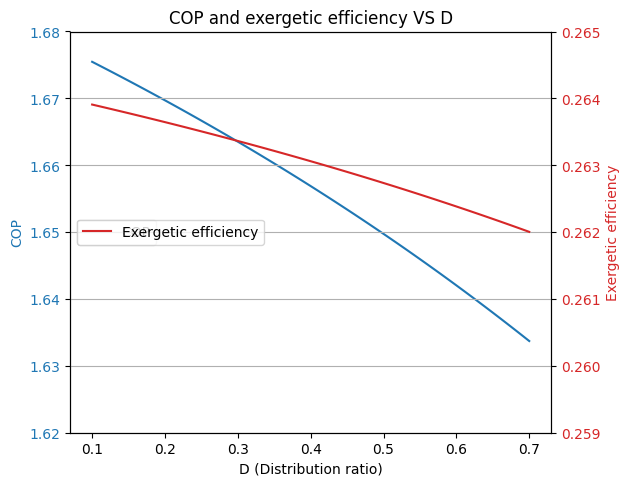

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = "fig11.xlsx"
excel_data = pd.ExcelFile(file_path)

# Read the specific sheet
df = excel_data.parse('Table 2')

# Clean the data by dropping rows with NaN values
df_clean = df.dropna()

# Create the plot
fig, ax1 = plt.subplots()

# Left Y-axis for COP
color = 'tab:blue'
ax1.set_xlabel('D (Distribution ratio)')
ax1.set_ylabel('COP', color=color)
# Plot original COP
ax1.plot(df_clean['D'], df_clean['COP'], color=color, linestyle='-', label='COP')

ax1.set_ylim(1.62, 1.68)

# Add legend
ax1.legend(loc='center left')
ax1.tick_params(axis='y', labelcolor=color)

# Right Y-axis for n_exergy_total
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Exergetic efficiency', color=color)
ax2.plot(df_clean['D'], df_clean['n_exergy_total'], color=color, linestyle='-', label='Exergetic efficiency')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='center left')
# Set right Y-axis limits only (no custom increment)
ax2.set_ylim(0.259, 0.265)

# Add grid and title
fig.tight_layout()
plt.title('COP and exergetic efficiency VS D')
plt.grid(True)

# Show the plot
plt.show()

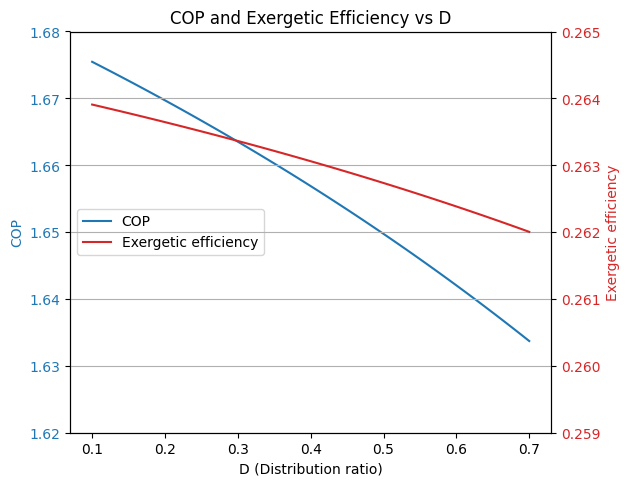

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = "fig11.xlsx"
excel_data = pd.ExcelFile(file_path)

# Read the specific sheet
df = excel_data.parse('Table 2')

# Clean the data by dropping rows with NaN values
df_clean = df.dropna()

# Create the plot
fig, ax1 = plt.subplots()

# Left Y-axis for COP
color = 'tab:blue'
ax1.set_xlabel('D (Distribution ratio)')
ax1.set_ylabel('COP', color=color)
line1, = ax1.plot(df_clean['D'], df_clean['COP'], color=color, linestyle='-', label='COP')
ax1.set_ylim(1.62, 1.68)
ax1.tick_params(axis='y', labelcolor=color)

# Right Y-axis for n_exergy_total
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Exergetic efficiency', color=color)
line2, = ax2.plot(df_clean['D'], df_clean['n_exergy_total'], color=color, linestyle='-', label='Exergetic efficiency')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0.259, 0.265)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center left')

# Add grid and title
fig.tight_layout()
plt.title('COP and Exergetic Efficiency vs D')
plt.grid(True)

# Show the plot
plt.show()
